In [ ]:
import math
import ast
import operator as op

class MathParser:
    """ Basic parser with local variable and math functions 
    
    Args:
       vars (mapping): mapping object where obj[name] -> numerical value 
       math (bool, optional): if True (default) all math function are added in the same name space
       
    Example:
       
       data = {'r': 3.4, 'theta': 3.141592653589793}
       parser = MathParser(data)
       assert parser.parse('r*cos(theta)') == -3.4
       data['theta'] =0.0
       assert parser.parse('r*cos(theta)') == 3.4
    """     
        
    _operators2method = {
        ast.Add: op.add, 
        ast.Sub: op.sub, 
        ast.BitXor: op.xor, 
        ast.Or:  op.or_, 
        ast.And: op.and_, 
        ast.Mod:  op.mod,
        ast.Mult: op.mul,
        ast.Div:  op.truediv,
        ast.Pow:  op.pow,
        ast.FloorDiv: op.floordiv,              
        ast.USub: op.neg, 
        ast.UAdd: lambda a:a  
    }
    
    def __init__(self, vars, math=True):
        self._vars = vars
        if not math:
            self._alt_name = self._no_alt_name
        
    def _Name(self, name):
        try:
            return  self._vars[name]
        except KeyError:
            return self._alt_name(name)
                
    @staticmethod
    def _alt_name(name):
        if name.startswith("_"):
            raise NameError(f"{name!r}") 
        try:
            return  getattr(math, name)
        except AttributeError:
            raise NameError(f"{name!r}") 
    
    @staticmethod
    def _no_alt_name(name):
        raise NameError(f"{name!r}") 
    
    def eval_(self, node):
        if isinstance(node, ast.Expression):
            return self.eval_(node.body)
        if isinstance(node, ast.Num): # <number>
            return node.n
        if isinstance(node, ast.Name):
            return self._Name(node.id) 
        if isinstance(node, ast.BinOp):            
            method = self._operators2method[type(node.op)]                      
            return method( self.eval_(node.left), self.eval_(node.right) )            
        if isinstance(node, ast.UnaryOp):             
            method = self._operators2method[type(node.op)]  
            return method( self.eval_(node.operand) )
        if isinstance(node, ast.Attribute):
            return getattr(self.eval_(node.value), node.attr)
            
        if isinstance(node, ast.Call):            
            return self.eval_(node.func)( 
                      *(self.eval_(a) for a in node.args),
                      **{k.arg:self.eval_(k.value) for k in node.keywords}
                     )           
        else:
            raise TypeError(node)
    
    def parse(self, expr,vars=None):
        if vars != None:
            self._vars=vars
        return  self.eval_(ast.parse(expr, mode='eval'))  

# Method 1

In [1]:
import ast
import operator as op

# supported operators
operators = {ast.Add: op.add, ast.Sub: op.sub, ast.Mult: op.mul,
             ast.Div: op.truediv, ast.Pow: op.pow, ast.BitXor: op.xor,
             ast.USub: op.neg}

def eval_expr(expr):
    """
    >>> eval_expr('2^6')
    4
    >>> eval_expr('2**6')
    64
    >>> eval_expr('1 + 2*3**(4^5) / (6 + -7)')
    -5.0
    """
    print(ast.parse(expr, mode='eval').body)
    return eval_(ast.parse(expr, mode='eval').body)

def eval_(node):
    if isinstance(node, ast.Num): # <number>
        return node.n
    elif isinstance(node, ast.BinOp): # <left> <operator> <right>
        return operators[type(node.op)](eval_(node.left), eval_(node.right))
    elif isinstance(node, ast.UnaryOp): # <operator> <operand> e.g., -1
        return operators[type(node.op)](eval_(node.operand))
    else:
        raise TypeError(node)

In [25]:
x=5
eval_expr("1+x")

TypeError: <ast.Name object at 0x0000023E7D1A7850>

# Method 2 *simple math only*

In [56]:
import re
# Kept outside simple_eval() just for performance
_re_simple_eval = re.compile(rb'd([\x00-\xFF]+)x*S\x00')


def simple_eval(expr):
    x=5
    try:
        c = compile(expr, 'userinput', 'eval')
    except SyntaxError:
        raise ValueError(f"Malformed expression: {expr}")
    m = _re_simple_eval.fullmatch(c.co_code)
    if not m:
        raise ValueError(f"Not a simple algebraic expression: {expr}")
    try:
        return c.co_consts[int.from_bytes(m.group(1), sys.byteorder)]
    except IndexError:
        print(c.co_consts)
        raise ValueError(f"Expression not evaluated as constant: {expr}")

In [61]:
try:
    result = simple_eval('2+x')
    print(result)
except ValueError as e:
    print(e)

(2,)
Expression not evaluated as constant: 2+x


In [49]:
for expr, res in (
    ('2^4',                         6      ),
    ('2**4',                       16      ),
    ('1 + 2*3**(4^5) / (6 + -7)',  -5.0    ),
    ('7 + 9 * (2 << 2)',           79      ),
    ('6 // 2 + 0.0',                3.0    ),
    ('2+3',                         5      ),
    ('6+4/2*2',                    10.0    ),
    ('3+2.45/8',                    3.30625),
    ('3**3*3/3+3',                 30.0    ),
    ('2',                           2     ),
):
    result = simple_eval(expr)
    ok = (result == res and type(result) == type(res))
    print("{} {} = {}".format("OK!" if ok else "FAIL!", expr, result))

<re.Match object; span=(0, 4), match=b'd\x00S\x00'>
OK! 2^4 = 6
<re.Match object; span=(0, 4), match=b'd\x00S\x00'>
OK! 2**4 = 16
<re.Match object; span=(0, 4), match=b'd\x00S\x00'>
OK! 1 + 2*3**(4^5) / (6 + -7) = -5.0
<re.Match object; span=(0, 4), match=b'd\x00S\x00'>
OK! 7 + 9 * (2 << 2) = 79
<re.Match object; span=(0, 4), match=b'd\x00S\x00'>
OK! 6 // 2 + 0.0 = 3.0
<re.Match object; span=(0, 4), match=b'd\x00S\x00'>
OK! 2+3 = 5
<re.Match object; span=(0, 4), match=b'd\x00S\x00'>
OK! 6+4/2*2 = 10.0
<re.Match object; span=(0, 4), match=b'd\x00S\x00'>
OK! 3+2.45/8 = 3.30625
<re.Match object; span=(0, 4), match=b'd\x00S\x00'>
OK! 3**3*3/3+3 = 30.0
<re.Match object; span=(0, 4), match=b'd\x00S\x00'>
OK! 2 = 2


In [53]:
for expr in (
    'foo bar',
    'print("hi")',
    '2*x',
    'lambda: 10',
    '2**1234',
    'X=12',
    'import math',
    '2+x'
):
    try:
        result = simple_eval(expr)
    except ValueError as e:
        print(e)
        continue
    print("OK!", result)  # will never happen

Malformed expression: foo bar
Not a simple algebraic expression: print("hi")
<code object <module> at 0x0000023E7DADD450, file "userinput", line 1>
Expression not evaluated as constant: 2*x
<code object <module> at 0x0000023E7DADD500, file "userinput", line 1>
Expression not evaluated as constant: lambda: 10
<code object <module> at 0x0000023E7DADD500, file "userinput", line 1>
Expression not evaluated as constant: 2**1234
Malformed expression: X=12
Malformed expression: import math
<code object <module> at 0x0000023E7DADD500, file "userinput", line 1>
Expression not evaluated as constant: 2+x


# testing plotting


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from LogicTest import MathParser

In [1]:
Parser=MathParser({'x':1})
xpoints=range(-1000,1000)
ypoints=[Parser.parse('x**2+2*x+1',{'x':x}) for x in xpoints]

NameError: name 'MathParser' is not defined

In [ ]:
print(ypoints)

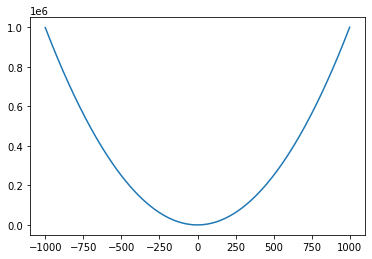

In [12]:
plt.plot(xpoints,ypoints)

In [5]:
parser=MathParser({'x':12})
for expr, res in (
    ('2**4',                        16     ),
    ('1 + 2*3**(4//5) // (6 + -7)', -1     ),
    ('7 + 9 * (2 + 2)',             43     ),
    ('6 // 2 + 0.0',                3.0    ),
    ('2+3',                         5      ),
    ('6+4/2*2',                    10.0    ),
    ('3+2.45/8',                    3.30625),
    ('3**3*3/3+3',                 30.0    ),
    ('2',                           2      ),
    ('x+50',                        62     ),
    ('x**2',                       144     ),
):


    result = parser.parse(expr)
    ok = (result == res and type(result) == type(res))
    print("{} {} = {}".format("OK!" if ok else "FAIL!", expr, result))

OK! 2**4 = 16
OK! 1 + 2*3**(4//5) // (6 + -7) = -1
OK! 7 + 9 * (2 + 2) = 43
OK! 6 // 2 + 0.0 = 3.0
OK! 2+3 = 5
OK! 6+4/2*2 = 10.0
OK! 3+2.45/8 = 3.30625
OK! 3**3*3/3+3 = 30.0
OK! 2 = 2
OK! x+50 = 62
OK! x**2 = 144


In [5]:
parser=MathParser()
expr='x**2+2*x+1'
result = parser.parse(expr)
print(result)

NameError: Variable 'x' is not provided. 